# Regression for morphological galaxy classification #4.2 (ResNet50)
---
**Author:** Jorge Barrio Conde

**Tfms:** `[Normalize.from_stats(mean=0.0, std=1.0), Rotate(p=1.0, draw=random_rotation), GaussianNoise()]`

**Neural Network:** ResNet50

**Training method:** `fine_tune()`

**Loss function:** ``rmse_label_smoothing``

**Epochs:** 30

**Learning rate:** default

Paper: *A catalog of visual-like mophologies in the 5 CANDELS fields using Deep-Learning* (M. Huertas-Company, 2015)

## 0. Install fastai and fastbook (Google Colab)

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

## 1. Setup

### Imports

In [ ]:
import fastai
from fastai.vision.all import *
from fastbook import *

fastai.__version__

'2.3.0'

### Paths

In [ ]:
# Specify project path
project_root_path = "/content/gdrive/MyDrive/galaxy_morphological_classification/"

In [ ]:
cat_file_path = project_root_path + "datasets/galaxies_main_props_with_struct_params_and_no_bad_objects_and_hudf_flags_and_morphs_and_z_flags6.cat"
png_files_path = project_root_path + "datasets/rgb_200x200/"
csv_results_path = project_root_path + "src/regression/results/4.2-ResNet50-TFMS-RMSE_label_smoothing-fine_tune-30_epochs.csv"

## 2. Prepare galaxies information

### Read .cat file

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

tt = Table.read(
    cat_file_path,
    names=[
        "gal_id","field","ra","dec","mass","z",
        "flag_fit","mag","dmag","re","dre","n","dn",
        "q","dq","pa","dpa","sn",
        "IAU_name","f_sph","f_disk","f_irr","f_ps",
        "f_unc","max_f","delta1-2","dom_class","entropy",
        "zspec","quality_zspec","zphot","zspec_legac","zspec_zcosmos",
        "confidence_class_zcosmos","zspec_legac_dr3","zspec_hathi","zspec_damjanov","zspec_damjanov_quality",
        "hudf_for_B","hudf_for_V","hudf_for_I","hudf_for_Y","hudf_for_J","hudf_for_H"
    ],
    format="ascii.commented_header")

gals = np.array(tt["gal_id"],dtype="U100")
ra = np.array(tt["ra"])
dec = np.array(tt["dec"])
field = np.array(tt["field"])
ar = np.array(tt["q"])
pa  = np.array(tt["pa"])
zz_old = np.array(tt["z"])
zspec = np.array(tt["zspec"])
quality_zspec = np.array(tt["quality_zspec"])
zphot = np.array(tt["zphot"])
zspec_legac = np.array(tt["zspec_legac"])
zspec_zcosmos = np.array(tt["zspec_zcosmos"])
confidence_class_zcosmos = np.array(tt["confidence_class_zcosmos"])
zspec_hathi = np.array(tt["zspec_hathi"])
zspec_legac_dr3 = np.array(tt["zspec_legac_dr3"])
zspec_damjanov = np.array(tt["zspec_damjanov"])

f_sph = np.array(tt["f_sph"])
f_disk = np.array(tt["f_disk"])
f_irr = np.array(tt["f_irr"])
f_ps = np.array(tt["f_ps"])
f_unc = np.array(tt["f_unc"])

### Create information dictionary

It's a dictionary with this structure:
> ```python
galaxies_fs = { morph_id_field.png : [f_sph, f_disk, f_irr, f_ps, f_unc] }
```

In [ ]:
def get_morphology_Huertas15(f_sph, f_disk, f_irr):
    if (f_sph > 0.667 and f_disk < 0.667 and f_irr < 0.1):
        return "SPH"
    elif (f_sph < 0.667 and f_disk > 0.667 and f_irr < 0.1):
        return "DISK"
    elif (f_sph > 0.667 and f_disk > 0.667 and f_irr < 0.1):
        return "DISKSPH"
    elif (f_sph < 0.667 and f_disk > 0.667 and f_irr > 0.1):
        return "DISKIRR"
    elif (f_sph < 0.667 and f_disk < 0.667 and f_irr > 0.1):
        return "IRR"
    else:
        return "NONE"

In [ ]:
galaxies_fs = {}
files = []

for i in range(len(gals)):
    morph = get_morphology_Huertas15(f_sph[i], f_disk[i], f_irr[i])

    filename = morph + "_" + gals[i] + "_" + field[i] + ".png"
    targets = [f_sph[i],f_disk[i],f_irr[i],f_ps[i],f_unc[i]]
    
    # Add a new item to the dictionary
    galaxies_fs.update({ filename : targets })

## 3. My functions

### 3.1. Getters

In [ ]:
import os

def get_y(source):
    '''
    Pre: file = source/morphology_id_field.png
    '''
    path = str(source)
    filename = os.path.basename(path)
    return galaxies_fs.get(filename) # Search in the dictionary

### 3.2. Tfms

In [ ]:
def random_rotation(x):
    '''
    Return a float tensor equal in size to batch with random
    rotations multiples of 90. 
    
    x: full batch tensor
    '''
    size = x.size(0)
    result = torch.zeros(([size]), dtype=float, device='cuda')
    
    for i in range(size):
        degree = torch.rand(1)
        if (degree < 0.25):
            result[i] = 0.0
        elif (degree < 0.5):
            result[i] = 90.0
        elif (degree < 0.75):
            result[i] = 180.0
        else:
            result[i] = 270.0
    
    return result

In [ ]:
class GaussianNoise(Transform):
    order = 100 #after normalize
    
    def encodes(self, x:TensorImage):
        noise = torch.normal(
            mean=0.0, 
            std=0.005,
            size=x.shape,
            device='cuda'
        )
        return x + noise

### 3.3.Loss and metrics

In [ ]:
def rmse_label_smoothing(preds, targs):
    targs += (torch.rand(targs.size(1),device='cuda')-0.5)*0.1
    return ((preds-targs)**2).mean().sqrt()  # rmse

### 3.4. Others

In [ ]:
def datasets_info(dls):
    for ds_i, ds in enumerate([dls.train_ds, dls.valid_ds]):
        
        ds_name = "TRAIN" if ds_i == 0 else "VALID"
        print(f"Dataset: {ds_name}")
        print(ds)
        
        print("")

## 4. Experiment

### 4.1. DataBlock and DataLoaders

In [ ]:
tfms = [Normalize.from_stats(mean=0.0, std=1.0), Rotate(p=1.0, draw=random_rotation), GaussianNoise()]

blocks = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_image_files,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=tfms
)

dls = blocks.dataloaders(source=png_files_path)

### 4.2. Show details

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

In [ ]:
datasets_info(dls)

Dataset: TRAIN
(#2768) [(PILImage mode=RGB size=200x200, tensor([0.9600, 0.3600, 0.0000, 0.0900, 0.0000])),(PILImage mode=RGB size=200x200, tensor([0.9300, 0.0000, 0.0000, 0.3500, 0.0000])),(PILImage mode=RGB size=200x200, tensor([0.3200, 1.0000, 0.0300, 0.0000, 0.0000])),(PILImage mode=RGB size=200x200, tensor([0.1200, 0.7400, 0.6400, 0.0000, 0.0000])),(PILImage mode=RGB size=200x200, tensor([0.0000, 0.8200, 0.5100, 0.0400, 0.0000])),(PILImage mode=RGB size=200x200, tensor([0.9100, 0.5200, 0.0000, 0.0200, 0.0000])),(PILImage mode=RGB size=200x200, tensor([0.8300, 0.8100, 0.3100, 0.0000, 0.0000])),(PILImage mode=RGB size=200x200, tensor([0.2600, 1.0000, 0.0700, 0.0000, 0.0000])),(PILImage mode=RGB size=200x200, tensor([0.6000, 1.0000, 0.0100, 0.0000, 0.0000])),(PILImage mode=RGB size=200x200, tensor([0.9700, 0.8700, 0.0000, 0.0100, 0.0000]))...]

Dataset: VALID
(#692) [(PILImage mode=RGB size=200x200, tensor([1.0000, 0.1700, 0.0000, 0.0000, 0.0000])),(PILImage mode=RGB size=200x200, te

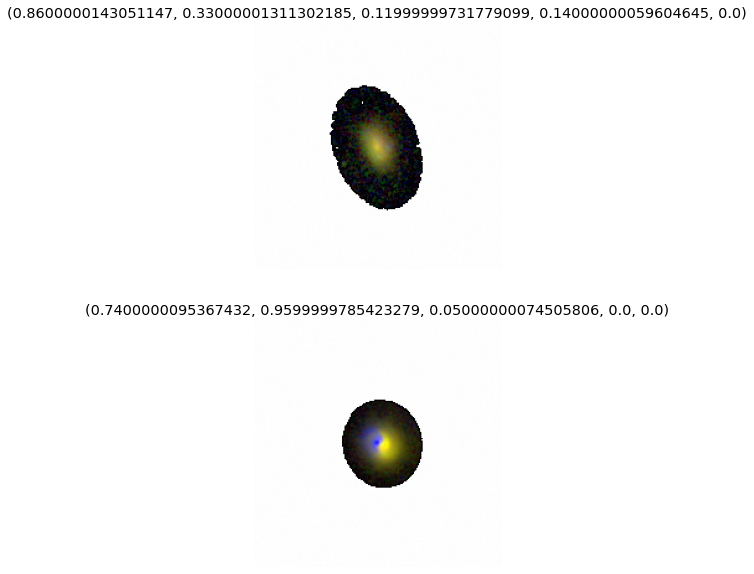

In [ ]:
dls.show_batch(nrows=2, ncols=1, figsize = (10, 10))

### 4.3. Learner and Training

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,_rmse,time
0,1.847562,1.266429,1.268162,04:34


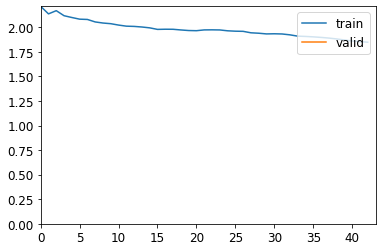

epoch,train_loss,valid_loss,_rmse,time
0,1.342367,0.563156,0.563792,00:33
1,1.251720,0.442353,0.442824,00:34
2,1.169119,0.433077,0.433730,00:33
3,1.075126,0.412494,0.413961,00:34
4,0.978065,0.388543,0.390083,00:34
5,0.870754,0.322497,0.324681,00:33
6,0.765379,0.298185,0.298620,00:34
7,0.654708,0.313524,0.319178,00:33
8,0.562856,0.208596,0.209230,00:34
9,0.490874,0.206177,0.207009,00:34


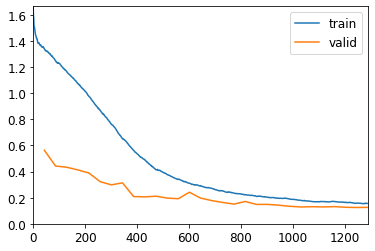

In [ ]:
learn = cnn_learner(
    dls, resnet50, 
    metrics = rmse,
    loss_func = rmse_label_smoothing,
    cbs = [
        ShowGraphCallback(),
        CSVLogger(fname=csv_results_path, append=true)
    ]
)

learn.fine_tune(epochs=30)